# Assesing the TESS-W sensor spectral response.

The TESS-W photometer mounts a TSL237 light-to-frequency plus a UV/IR cutoff filter where the IR part is limited to 750nm. An experimental measurement run of the whole device spectral response was made using the LICA Optical Test Bench, measuring the output frequency of the TESS-W device at a given wavelength, ranging from 350 nm to 1049 nm. An OSI PIN-10D calibrated laboratory photodiode was used as a reference comparison. We'd also like to compare the obtained results with the TSL237 manufacturer datasheet.

The output of the measurement session is a series of CSV files for the TESS-W and the laboratory photodiode. This Jupyter notebook shows a reduction session for this measurements an also the comparison between the theoretical values and the ones obtained at LICA.

To help us with the task, we have devoloped a Python package, namely `licaplot` that performs the data reduction process (thus keeping this notebook short) and is also able to produce some graphics standalone (not using Jupyter). There is also a basic `lica` Python package which contains information about the laboratory photodiodes.

The `licaplot` package makes heavy use of [Astropy's Tables](https://docs.astropy.org/en/stable/table/index.html). Theses tables are stored as ECSV files and contain the original measurements along with additional columns produced by the processing and metadata for bookeeping purposes.

## Installation

To be able to replicate the results of this notebook, the following steps are needed:
1. Download the [source code](https://github.com/guaix-ucm/licaplot) from GitHub using `git clone https://github.com/guaix-ucm/licaplot.git`. The `data/` subdirectory containing the datasets is not packaged with `licaplot`.
2. Create a virtual environment inside the `licaplot/` directory and activate it.
3. Install `licaplot` and `jupyter` in the same environment with `pip`
5. Run `jupyter notebook`
6. Navigate with the browser to the `doc` folder and open the `TESS-W Spectral Response.ipynb` notebook.

## The preamble 

First we start by importing the necessary Python packages, functions and constants. 


In [86]:
import itertools
from pathlib import Path
from typing import Optional, Sequence, Iterable, Tuple

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Column
import astropy.units as u

from lica.photodiode import PhotodiodeModel
from licaplot import filters, tessw
from licaplot.utils import processing
from licaplot.utils.mpl import MONOCROMATOR_FILTERS_LABELS


It is also very useful to verify that all files exists can be accessed before using the data reduction routines. The actual sample data are not packaged with `licaplot` itself, but they are available in the [`licaplot` GitHub repository](https://github.com/guaix-ucm/licaplot), unde the `data` directory.


In [87]:
DATA_DIR1 = Path("../data/tessw").resolve()
DATA_DIR2 = Path("../data/filters").resolve()

UVIR_FILTER_PATH = DATA_DIR2 /  "SP750_QEdata.txt"
UVIR_FILTER_PHOTOD_PATH = DATA_DIR2 / "SP750_Photodiode_QEdata.txt"
TESSW_READINGS_PATH =  DATA_DIR1 / "stars1277-frequencies.csv"
TESSW_PHOTOD_PATH = DATA_DIR1 / "stars1277-photodiode.csv"
TSL237_DATASHEET_PATH = DATA_DIR1 / "TSL237_normalized_responsivity.csv"

assert UVIR_FILTER_PATH.exists()
assert UVIR_FILTER_PHOTOD_PATH.exists()
assert TESSW_READINGS_PATH.exists()
assert TESSW_PHOTOD_PATH.exists()
assert TSL237_DATASHEET_PATH.exists()

We also define a couple of useful functions to plot results obtained by the processing

In [88]:
def get_labels(x: Column, y: Column) -> Tuple[str, str]:
    """Get the labels for a table column, using units if necessary"""
    xunit = x.unit
    yunit = y.unit
    xlabel = x.name + f" [{xunit}]" if xunit != u.dimensionless_unscaled else x.name
    ylabel = y.name + f" [{yunit}]" if yunit != u.dimensionless_unscaled else y.name
    return xlabel, ylabel

The convenient function below allows to an overlapped plot of a series of input Astropy Table columns. The `filters` flag allows us to display where the LICA Optical Test Bench changes rejection filters.

In [89]:
markers = itertools.cycle(["."]) # Customizable list of plot markers

def plot_overlapped(
    title: Optional[str],
    x: Iterable[Column],
    y: Iterable[Column],
    labels: Iterable[str],
    filters: Optional[bool],
    linewidth: Optional[int] = 0,
) -> None:
    """Plot all datasets in the same Axes using different markers"""
    fig, axes = plt.subplots(nrows=1, ncols=1)
    if title is not None:
        fig.suptitle(title)
    xlabel, ylabel = get_labels(x[0], y[0]) # Obrtain labes from the first columns
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    for xcol, ycol, label, marker in zip(x, y, labels, markers):
        axes.plot(xcol, ycol, marker=marker, linewidth=linewidth, label=label)
    if filters:
        for filt in MONOCROMATOR_FILTERS_LABELS:
            axes.axvline(filt["wavelength"], linestyle=filt["style"], label=filt["label"])
    axes.grid(True, which="major", color="silver", linestyle="solid")
    axes.grid(True, which="minor", color="silver", linestyle=(0, (1, 10)))
    axes.minorticks_on()
    axes.legend()

## Obtaining the theoretical response

The manufacturer TSL237 datasheet presents [the following normalized responsivity](image/tsl234_normalized_responsivity.jpg). With the help of a digitizer too, we extracted the calibrated (x,y) datapoints and stored them in a `TES237_normalized_responsivity.csv` CSV file. The file shows irregular sampling, which is resampled at 5nm uniform resolution to match the TESS-W sampling resolution and trimmed to the LICA Optical TestBench range of 350-1050 nm.

In [90]:
manuf_raw_table = processing.read_tsl237_datasheet_csv(path = TSL237_DATASHEET_PATH)


In [91]:
tsl237_table = processing.tsl237_table(
    path = TSL237_DATASHEET_PATH, 
    label = "TSL237 datasheet", 
    resolution= 5
)

$$
QE = \frac{h c R_{e}}{\lambda}
$$

where $h$ is the Planck's constant, $c$ is the speed of the light, $\lambda$ is the wavelength and $R_{e}$ is the device responsivity in A/W so that $QE$ is dimensioneless and $<1$. In this particula case, the responsivity curve $R_e$ given by the manufacturer is normalized in the datasheet, there is a missing scale factor which makes $QE$ > 1 and we will have to address later on.

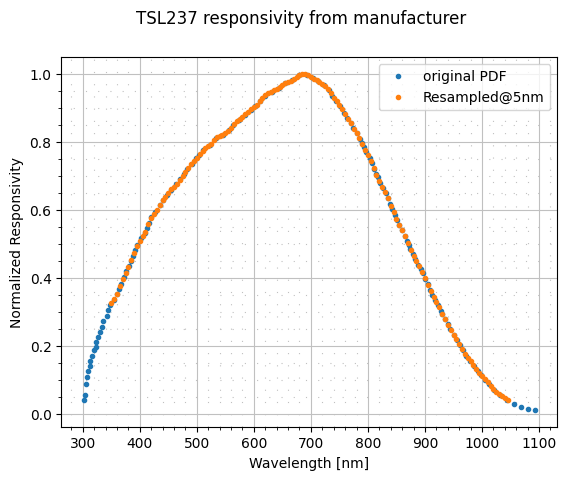

In [92]:
plot_overlapped(
    title = "TSL237 responsivity from manufacturer",
    x = [manuf_raw_table["Wavelength"], tsl237_table["Wavelength"]],
    y = [manuf_raw_table["Normalized Responsivity"],tsl237_table["Normalized Responsivity"]],
    labels = ["original PDF", "Resampled@5nm"],
    filters = False,
    linewidth = 0,
)

To be able to compare the TSL237 `Spectral Response` with the measured the TESS-W `Spectral Response`, we must cut off this spectrum by the UV/IR cutoff filter used by TESS-W. As we do not have the transmission curve for this UV/IR filter, we measured one of such filters in the LICA Test Bench. The function below process the clear and filtered reference photodiode readings to return an Astropy table, saved in ECSV format. This table contains a `Transmission` column with the computed filter transmission.

In [93]:
filter_path = filters.one_filter(
    input_path = UVIR_FILTER_PATH,
    photod_path = UVIR_FILTER_PHOTOD_PATH,
    model = PhotodiodeModel.OSI.value,
    label = "UV/IR cut 750nm"
)
print(filter_path)

/home/rafa/repos/own/guaix/licaplot/data/filters/SP750_QEdata.ecsv


Now, we perform the correction multiplying the TSL237 `Spectral Response` by the cut-off filter `Transmission`

In [94]:
filter_table = processing.read_ecsv(filter_path)
tsl237_table["Spectral Response"] = tsl237_table["Spectral Response"] / np.max(tsl237_table["Spectral Response"])
tsl237_table["Corrected Spectral Response"] = np.round(tsl237_table["Spectral Response"] * 
                                                       filter_table["Transmission"], decimals=5) * u.dimensionless_unscaled

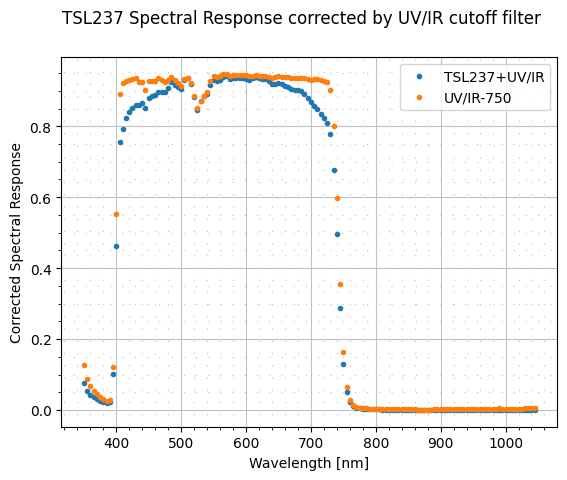

In [95]:
plot_overlapped(
    title = "TSL237 Spectral Response corrected by UV/IR cutoff filter",
    x = [tsl237_table["Wavelength"], filter_table["Wavelength"]],
    y = [tsl237_table["Corrected Spectral Response"], filter_table["Transmission"]],
    labels = ["TSL237+UV/IR", "UV/IR-750"],
    filters = False,
    linewidth = 0,
)

Note the dip in the TESL237 curve above is due to this particular UV/IR cutoff filter sample we chose.

## TESS-W measured Spectral Response

The function below reads the input CSV files obtained by the TESS-W adcquistion program and the laboratory photodiode readings and performs the data reduction to obtain a table which contains a `Spectral Response` (the sensor $QE$). 

Under the even illumination conditions given by the LICA Optical test bench, and using a laboratoty photodiode with a known, calibrated $QE$:

$$
    \frac{QE_{tess}}{QE_{photod}} = \frac{I_{tess}}{I_{photod}}
$$

Since the TSL237 is a itself photodiode with an additional circuitry whose frequency $f_{tess}$ is proportional to the generated current $f_{tess} = I_{tess} / g$ where $g$ is a gain factor given in $A/Hz$:

$$
    SR_{tess} \equiv QE_{tess} = \frac{f_{tess} \times g}{I_{photod}} \times QE_{photod}
    $$

 Since the gain $g$ is unknown, we use a ficticious `gain` factor of 1 nA/Hz.

In [96]:
tessw_path = tessw.one_tessw(
    input_path = TESSW_READINGS_PATH,
    photod_path = TESSW_PHOTOD_PATH,
    model = PhotodiodeModel.OSI.value,
    label = "TESS-W",
    gain = 1 * u.nA / u.Hz,
)
print(tessw_path)

/home/rafa/repos/own/guaix/licaplot/data/tessw/stars1277-frequencies.ecsv


In [97]:
# Read and normalize the spectral response
tessw_table = processing.read_ecsv(tessw_path)
tessw_table["Spectral Response"] = tessw_table["Spectral Response"]/ np.max(tessw_table["Spectral Response"])

The first rows are shown below:

In [98]:
tessw_table

Wavelength,Frequency,Photodiode Electrical Current,Photodiode QE,Spectral Response
nm,Hz,A,,
float64,float64,float64,float64,float64
350.0,0.78,2.776791e-10,0.14864,0.1518083353739917
355.0,0.9,3.919527e-10,0.13144,0.10973493512502565
...,...,...,...,...
1040.0,0.73,9.861473e-09,0.49317,0.013273523777749648
1045.0,0.73,8.57517e-09,0.44879,0.013890945415232097


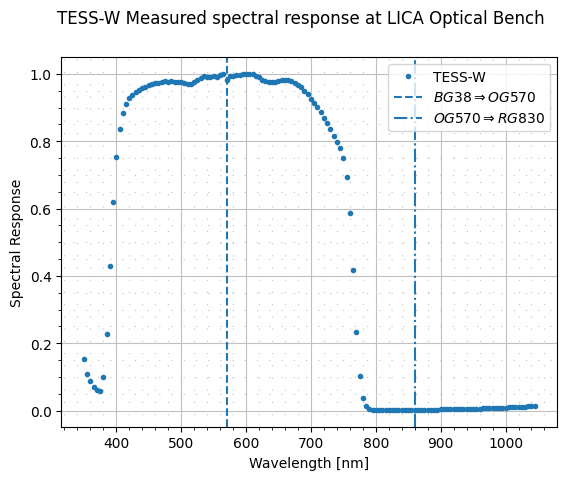

In [99]:
plot_overlapped(
    title = "TESS-W Measured spectral response at LICA Optical Bench",
    x = [tessw_table["Wavelength"]],
    y = [tessw_table["Spectral Response"]],
    labels = ["TESS-W"],
    filters = True,
    linewidth = 0,
)

# Comparison of results

At first glance, we have two normalized curves with the same shape, but with slight different scales due to unknown scale factors in both. We'll try to estimate a scale factor that minimizes the cuadratic error between both data sets. If we denote $y_{theo}$ the TSL237+UV/IR data obtained by the datasheet corrected by the UV/IR cutoff and $y_{obs}$ the dataset obtained from measuring the TESS-W response, the expression becomes:

In [100]:
y_obs = tessw_table["Spectral Response"]
y_theo = tsl237_table["Corrected Spectral Response"]

$$
  Err = \sum_1^N (K*y_{theo} - y_{obs})^2
$$

The scale factor that minimizes this cuadratic error is given by:

$$
  K = \frac{\sum_1^N y_{obs}*y_{theo}}{\sum_1^N y_{theo}^2}
$$

In [101]:
K = np.sum(y_obs * y_theo) / np.sum(np.square(y_theo))
K

1.0890424297938137

Then, we proceed to plot both dataset in the same graphics:

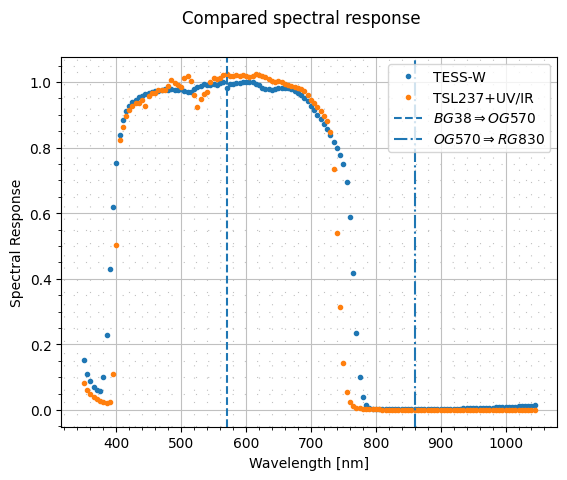

In [102]:
plot_overlapped(
    title = "Compared spectral response",
    x = [tsl237_table["Wavelength"], tsl237_table["Wavelength"]],
    y = [y_obs, K*y_theo],
    labels = ["TESS-W", "TSL237+UV/IR"],
    filters = True,
    linewidth = 0,
)

# Conclussion

The plot confirms our hypothesis and also suggest that the TESS-W device mounts a slightly wider UV/IR cut off filter.